In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import h5py
import scipy
from torch.utils.data import Dataset, DataLoader

# look at functions

In [36]:

import h5py
import scipy

import bilby
from bilby.gw import utils as gwutils
from pesummary.gw.conversions import spins as pespin
from bilby.gw import conversion

def make_dtphis(injection_parameters,
        duration, f_lower,sampling_frequency,
        approximant_list=['IMRPhenomPv2','SEOBNRv4P'],
        mode='plus',f_ref=50):
    ''' 
    Waveforms are aligned with the 1st model in approximant_list.
    '''
    ifos = bilby.gw.detector.InterferometerList(['L1'])
    det = ifos[0]
    det.duration = duration
    det.sampling_frequency=sampling_frequency
    det.frequency_mask = det.frequency_array>=f_lower
    mask = det.frequency_mask
    freq_array = det.frequency_array[mask]
    
    h_list = []
    
    if mode in ['plus', 'cross']:
        for i,approx in enumerate(approximant_list):
            if approx=='NRSur7dq4':
                waveform_arguments = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=0)  # 0: auto choose (still have bug here)
            else:
                waveform_arguments = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=f_lower)


            waveform_generator = bilby.gw.WaveformGenerator(
                duration=duration, sampling_frequency=sampling_frequency,
                frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                waveform_arguments=waveform_arguments)


            h = waveform_generator.frequency_domain_strain(parameters=injection_parameters)[mode]
            if i==0:
                h_list.append(h)
            else:
                #h = get_shifted_h2_zeropad(h_list[0],h,det)
                deltat,deltaphi = get_dtdphi_withift_zeropad(h_list[0],h,det)
        return deltat,deltaphi
    
    
    elif mode == 'both':
        raise Exception('Under development!')
        # h_list = [approx1_plus, approx1_cross, approx2_plus, approx2_cross, ...]
        for i,approx in enumerate(approximant_list):
            if approx=='NRSur7dq4':
                waveform_arguments = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=0)  # 0: auto choose
            else:
                waveform_arguments = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=f_lower)


            waveform_generator = bilby.gw.WaveformGenerator(
                duration=duration, sampling_frequency=sampling_frequency,
                frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                waveform_arguments=waveform_arguments)


            h = waveform_generator.frequency_domain_strain(parameters=injection_parameters)
            for j,m in enumerate(['plus', 'cross']):
                if i==0:
                    h_list.append(h[m])
                else:
                    hh = get_shifted_h2_zeropad(h_list[j],h[m],det)
                    h_list.append(hh)
        
        h_masked = []
        for h_to_mask in h_list:
            h_masked.append(h_to_mask[mask])

        return freq_array, h_masked


def get_inj_paras(parameter_values,
                  parameter_names = ['chirp_mass','mass_ratio','a_1','a_2','tilt_1','tilt_2','phi_12','phi_jl',
                                     'theta_jn','psi','phase','ra','dec','luminosity_distance','geocent_time']):
    inj_paras = dict()
    for i, para_name in enumerate(parameter_names):
        inj_paras[para_name] = parameter_values[i]
    return inj_paras 

def my_inner_product(hf1,hf2,det,flag):
    inner_prod_complex = gwutils.noise_weighted_inner_product(
                            aa=hf1[det.strain_data.frequency_mask],
                            bb=hf2[det.strain_data.frequency_mask],
                            power_spectral_density=det.power_spectral_density_array[det.strain_data.frequency_mask],
                            duration=det.strain_data.duration)

    #inner_prod_complex = det.inner_product_2(hf1, hf2)
    if flag == "c":
        return inner_prod_complex
    elif flag == "r":
        return np.real(inner_prod_complex)
    else:
        raise("Wrong flag!")


def get_dtdphi_withift_zeropad(h1,h2,det):

    psd = det.power_spectral_density_array
    f_array = det.frequency_array
    
    X_of_f = h1*h2.conjugate()/psd
    add_zero = np.zeros(int(7*len(X_of_f)))
    X_of_f = np.append(X_of_f,add_zero)
    X_of_t = np.fft.ifft(X_of_f)
    
    timelength = 1/(f_array[1]-f_array[0])
    t = np.linspace(-timelength/2,timelength/2,len(X_of_t))
    X_shifted = np.roll(X_of_t,len(X_of_t)//2)

    jmax = np.argmax( abs(X_shifted) )
    deltat = t[jmax]
    phase1 = 2*np.pi*f_array*deltat
    
    freq_mask = det.strain_data.frequency_mask
    inner_product = my_inner_product(h1.conjugate(), h2.conjugate()*np.exp(1j*phase1), det, 'c')
    
    '''
    gwutils.noise_weighted_inner_product(
                    aa=h1.conjugate()[freq_mask],
                    bb=(h2.conjugate()*np.exp(1j*phase1))[freq_mask],
                    power_spectral_density=det.power_spectral_density_array[freq_mask],
                    duration=det.strain_data.duration)'''
    
    deltaphi = -np.angle(inner_product)
    #phase2 = deltaphi
    
    return deltat,deltaphi


In [38]:
N=100
#q = np.logspace(np.log10(0.5),0,N)  # q from 0.5 to 1
q = np.linspace(0.7,1,N)

#Mtot=60
#Mtot=25  # minimum m2=5 for qmin=0.25
Mtot=40  # minimum m2=8 for qmin=0.25

mass_1 = Mtot/(1+q)
mass_2 = mass_1*q

mass_ratio = np.zeros(N) + q
chirp_mass = conversion.component_masses_to_chirp_mass(mass_1,mass_2)
fref_list = np.zeros(N)+50.0
theta_jn = np.zeros(N)
phi_jl = np.zeros(N)
tilt_1 = np.zeros(N)
tilt_2 = np.zeros(N)
phi_12 = np.zeros(N)
a_1 = np.zeros(N)
a_2 = np.zeros(N)


luminosity_distance = np.zeros(N) + 100
phase = np.zeros(N)

# unimportant paras
geocent_time= np.zeros(N)
psi = np.zeros(N)
ra = np.zeros(N)
dec = np.zeros(N)


para_list = [chirp_mass,mass_ratio,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,
                theta_jn, psi, phase, ra, dec, luminosity_distance, geocent_time]

samples = np.zeros(shape=(N,len(para_list)) )

for i in range(len(para_list)):
    samples[:,i] = para_list[i] 


duration=16*2
f_lower=20
sampling_frequency=4096*2

approximant_list = ['IMRPhenomPv2','SEOBNRv4P']

n_approx = len(approximant_list)

data_dict = dict()

data_dict['source_parameters'] = dict()
parameter_name_list = ['chirp_mass','mass_ratio','a_1','a_2','tilt_1','tilt_2','phi_12','phi_jl','theta_jn']
for paraname in parameter_name_list:
    data_dict['source_parameters'][paraname] = []

data_dict['outputs'] =  dict()
for outputname in ['dt', 'dphi']:
    data_dict['outputs'][outputname] = []

for waveform_index in range(N):
    # calculation
    if i%100 ==0:
        print(f"Flag: {i}-th simulation.")
    injection_para = get_inj_paras(samples[waveform_index])

    deltat,deltaphi = make_dtphis(injection_para,
        duration, f_lower, sampling_frequency,
        approximant_list=approximant_list, mode='plus')

    data_dict['outputs']['dt'].append(deltat)
    data_dict['outputs']['dphi'].append(deltaphi)

    for paraname in parameter_name_list:
        data_dict['source_parameters'][paraname].append(injection_para[paraname])

14:01 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:01 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:01 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:01 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:01 bi

2

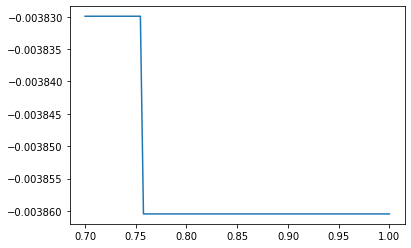

In [39]:
plt.plot(q, data_dict['outputs']['dt'])

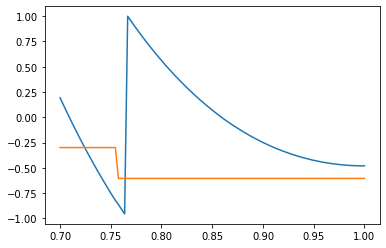

In [67]:
plt.plot(q, np.array(data_dict['outputs']['dphi'])/np.pi)
plt.plot(q, (np.array(data_dict['outputs']['dt'])+0.0038)*10000)

In [60]:
np.full((4,3),np.array([1,2,3])).T

array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]])

In [68]:
np.full((4,3),[1,2,3]).T

array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]])

In [53]:
np.full((4,3),np.array([1,2,3]))

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

# training

In [30]:
device = torch.device("cpu")
#device = torch.device("cuda:0")

In [31]:
class DTDPHI_9Dinput_q7a5M40(Dataset):
    def __init__(self, h5file, index, transform=None):
        
        with h5py.File(h5file, "r") as f:
            a1 = torch.tensor(list(f['source_parameters']['a_1'])) * 2
            a2 = torch.tensor(list(f['source_parameters']['a_2'])) * 2
            chirp_mass = (torch.tensor(list(f['source_parameters']['chirp_mass'])) - 17) * 2
            mass_ratio = (torch.tensor(list(f['source_parameters']['mass_ratio'])) - 0.7) * 3
            phi_12 = torch.tensor(list(f['source_parameters']['phi_12'])) / np.pi
            phi_jl = torch.tensor(list(f['source_parameters']['phi_jl'])) / np.pi
            theta_jn = torch.tensor(list(f['source_parameters']['theta_jn'])) / np.pi
            tilt_1 = torch.tensor(list(f['source_parameters']['tilt_1'])) / np.pi
            tilt_2 = torch.tensor(list(f['source_parameters']['tilt_2'])) / np.pi
            self.x = torch.stack((chirp_mass,mass_ratio,a1,a2,phi_12,phi_jl,theta_jn,tilt_1,tilt_2),dim=1)
            
            
            
            dphi = torch.tensor(list(f['outputs']['dphi'])) / (2*np.pi)
            dt = (torch.tensor(list(f['outputs']['dt'])) / 0.01 + 0.4) * 25
            self.y = torch.stack((dphi,dt),dim=1)
            
        self.transform = transform
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        
        if self.transform is not None:
            pass
                                      
        return self.x[index], self.y[index]
    
    
class DTDPHI_8Dinput_q7a5M40(Dataset):
    def __init__(self, h5file, index, transform=None):
        
        with h5py.File(h5file, "r") as f:
            a1 = torch.tensor(list(f['source_parameters']['a_1'])) * 2
            a2 = torch.tensor(list(f['source_parameters']['a_2'])) * 2
            #chirp_mass = (torch.tensor(list(f['source_parameters']['chirp_mass'])) - 17) * 2
            mass_ratio = (torch.tensor(list(f['source_parameters']['mass_ratio'])) - 0.7) * 3
            phi_12 = torch.tensor(list(f['source_parameters']['phi_12'])) / np.pi
            phi_jl = torch.tensor(list(f['source_parameters']['phi_jl'])) / np.pi
            theta_jn = torch.tensor(list(f['source_parameters']['theta_jn'])) / np.pi
            tilt_1 = torch.tensor(list(f['source_parameters']['tilt_1'])) / np.pi
            tilt_2 = torch.tensor(list(f['source_parameters']['tilt_2'])) / np.pi
            #self.x = torch.stack((chirp_mass,mass_ratio,a1,a2,phi_12,phi_jl,theta_jn,tilt_1,tilt_2),dim=1)
            self.x = torch.stack((mass_ratio,a1,a2,phi_12,phi_jl,theta_jn,tilt_1,tilt_2),dim=1)
            
            
            dphi = torch.tensor(list(f['outputs']['dphi'])) / (2*np.pi)
            dt = (torch.tensor(list(f['outputs']['dt'])) / 0.01 + 0.4) * 25
            self.y = torch.stack((dphi,dt),dim=1)
            
        self.transform = transform
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        
        if self.transform is not None:
            pass
                                      
        return self.x[index], self.y[index]

DT_FACTOR = 300
class DTDPHI_5Dinput_q10a99M40(Dataset):
    def __init__(self, h5file, select_index, mode='plus', device='cpu'):
        
        with h5py.File(h5file, "r") as f:
            a1 = torch.tensor(list(f['source_parameters']['a_1']))[select_index]
            a2 = torch.tensor(list(f['source_parameters']['a_2']))[select_index]
            mass_ratio = torch.tensor(list(f['source_parameters']['mass_ratio']))[select_index]
            theta_jn = torch.tensor(list(f['source_parameters']['theta_jn']))[select_index] / np.pi
            f_ref = (torch.tensor(list(f['source_parameters']['f_ref']))[select_index] - 5 )/195
            self.x = torch.stack((mass_ratio,a1,a2,theta_jn,f_ref),dim=1).to(device)
            
            
            dphi = torch.tensor(list(f['outputs'][f'dphi_{mode}']))[select_index] / np.pi
            dt = torch.tensor(list(f['outputs'][f'dt_{mode}']))[select_index] * DT_FACTOR
            
            self.y = torch.stack((dphi,dt),dim=1).to(device)
                    
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):     
        return self.x[index], self.y[index]

In [370]:
N=5000

rand_index = np.random.permutation(N)
train_index = rand_index[:int(N*0.98)]
valid_index = rand_index[int(N*0.98):int(N*0.99)]
test_index = rand_index[int(N*0.99):]

#train_dataset = DTDPHI_9Dinput_q7a5M40(h5filename, train_index)
#valid_dataset = DTDPHI_9Dinput_q7a5M40(h5filename, valid_index)
#test_dataset = DTDPHI_9Dinput_q7a5M40(h5filename, test_index)
#train_dataset = DTDPHI_8Dinput_q7a5M40(h5filename, train_index)
#valid_dataset = DTDPHI_8Dinput_q7a5M40(h5filename, valid_index)
#test_dataset = DTDPHI_8Dinput_q7a5M40(h5filename, test_index)

input_folder = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/utils/waveform_alignment/training_data/'
output_folder = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/utils/waveform_alignment/outputs/'
phy='ASHM'
#phy='AS'
#mode='plus'
mode='cross'
h5filename = f'{input_folder}dtdphi_5D_q10a99M40_IMREOB_{phy}.h5'

train_dataset = DTDPHI_5Dinput_q10a99M40(h5filename, train_index, mode=mode, device=device)
valid_dataset = DTDPHI_5Dinput_q10a99M40(h5filename, valid_index, mode=mode, device=device)
test_dataset = DTDPHI_5Dinput_q10a99M40(h5filename, test_index, mode=mode, device=device)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [378]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            #nn.LeakyReLU(),
            #nn.Linear(256, 256),
            #nn.LeakyReLU(),
            #nn.Linear(256, 256),
            #nn.LeakyReLU(),
            #nn.Linear(256, 256),
            #nn.Dropout(p=0.5),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            #nn.Dropout(p=0.5),
            nn.LeakyReLU(),
            nn.Linear(128, 2)
        )


    def forward(self, x):
        return self.layers(x)
    
class MLPtest(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers1 = nn.Sequential(
            nn.Linear(5, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 5)
        )

        self.layers2 = nn.Sequential(
            nn.Linear(5, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 2)
        )


    def forward(self, x):
        return self.layers2(self.layers1(x) + x)

In [379]:

mlp = MLP().to(device)
loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
epochs = 3000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [380]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []

checkpoint_filename = f"{output_folder}checkpoint_{phy}_{mode}_5d_q10a99.pickle"
best_epoch = 0
print("Training started.")
for epoch in range(epochs):
    mlp.train()
    
    train_losses = []
    valid_losses = []
    for i, data in enumerate(train_loader):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        optimizer.zero_grad()
        
        outputs = mlp(inputs)
        loss = loss_function(outputs, targets)
        #loss = weighted_loss_function(outputs, targets, weight_for_dt)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
            
    mlp.eval()

    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            inputs_valid, targets_valid = data
            inputs_valid, targets_valid = inputs_valid.float(), targets_valid.float()
            outputs_valid = mlp(inputs_valid)
            loss_valid = loss_function(outputs_valid, targets_valid)
            #loss_valid = weighted_loss_function(outputs_valid, targets_valid, weight_for_dt)

            valid_losses.append(loss_valid.item())
    
    if epoch>0:
        if np.mean(valid_losses)<min(mean_valid_losses):
            torch.save(mlp.state_dict(), checkpoint_filename)
            best_epoch = epoch

    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    if not epoch%500 or epoch==(epochs-1):
        print('epoch : {}, train loss : {:.8f}, valid loss : {:.8f}'\
             .format(epoch, np.mean(train_losses), np.mean(valid_losses)))
print("Training finished.")
print(f"Loading from the best epoch: {best_epoch}, best loss: {min(mean_valid_losses)}")
mlp.load_state_dict(torch.load(checkpoint_filename))

Training started.
epoch : 0, train loss : 0.18091938, valid loss : 0.17563465
epoch : 500, train loss : 0.04128091, valid loss : 0.19833636
epoch : 1000, train loss : 0.01246948, valid loss : 0.23927289
epoch : 1500, train loss : 0.00659927, valid loss : 0.26088277
epoch : 2000, train loss : 0.00508826, valid loss : 0.22671025


KeyboardInterrupt: 

In [313]:
best_epoch

2551

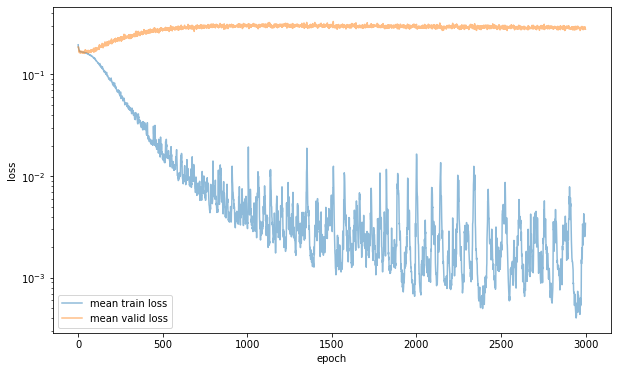

In [355]:
plt.figure(figsize=(10,6))
plt.plot(mean_train_losses, label='mean train loss',alpha=0.5)
plt.plot(mean_valid_losses, label='mean valid loss',alpha=0.5)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.yscale('log')
plt.show()

In [316]:
test_losses = []

true_dt = []
true_dphi = []

predicted_dt = []
predicted_dphi = []
mlp.eval()
with torch.no_grad():
    for testid in test_index:
        inputs_test, targets_test = test_dataset[testid]
        inputs_test, targets_test = inputs_test.float(), targets_test.float()
        
        true_dphi.append((targets_test[0]*np.pi).to(torch.device("cpu")))
        true_dt.append((targets_test[1]/DT_FACTOR).to(torch.device("cpu")))
        
        outputs_test = mlp(inputs_test)
        predicted_dphi.append((outputs_test[0]*np.pi).to(torch.device("cpu")))
        predicted_dt.append((outputs_test[1]/DT_FACTOR).to(torch.device("cpu")))
        
        loss_test = loss_function(outputs_test, targets_test)
        test_losses.append(loss_valid.item())
        
true_dt = np.array(true_dt)
true_dphi = np.array(true_dphi)
predicted_dt = np.array(predicted_dt)
predicted_dphi = np.array(predicted_dphi)

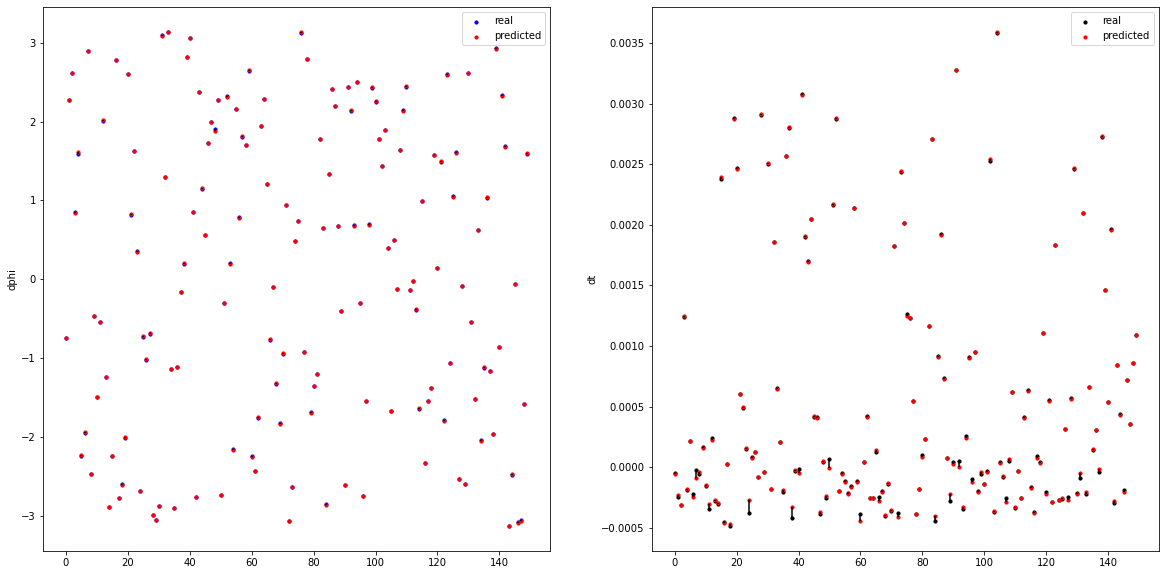

In [317]:
plt.figure(figsize=(20,10))
scatter_size = 10

plt.subplot(1,2,1)
plt.scatter(np.arange(len(test_index)), true_dphi,label='real',color='b',s=scatter_size)
plt.scatter(np.arange(len(test_index)), predicted_dphi,label='predicted',s=scatter_size,color='r')
for i in range(len(test_index)):
    plt.vlines(x=np.arange(len(test_index))[i], 
               ymin=min(true_dphi[i],predicted_dphi[i]), ymax=max(true_dphi[i],predicted_dphi[i]), color='k')
plt.ylabel('dphi')
plt.legend()


plt.subplot(1,2,2)
plt.scatter(np.arange(len(test_index)), true_dt,label='real',color='k',s=scatter_size)
plt.scatter(np.arange(len(test_index)), predicted_dt,label='predicted',s=scatter_size,color='r')
for i in range(len(test_index)):
    plt.vlines(x=np.arange(len(test_index))[i], 
               ymin=min(true_dt[i],predicted_dt[i]), ymax=max(true_dt[i],predicted_dt[i]), color='k')
plt.ylabel('dt')
plt.legend()

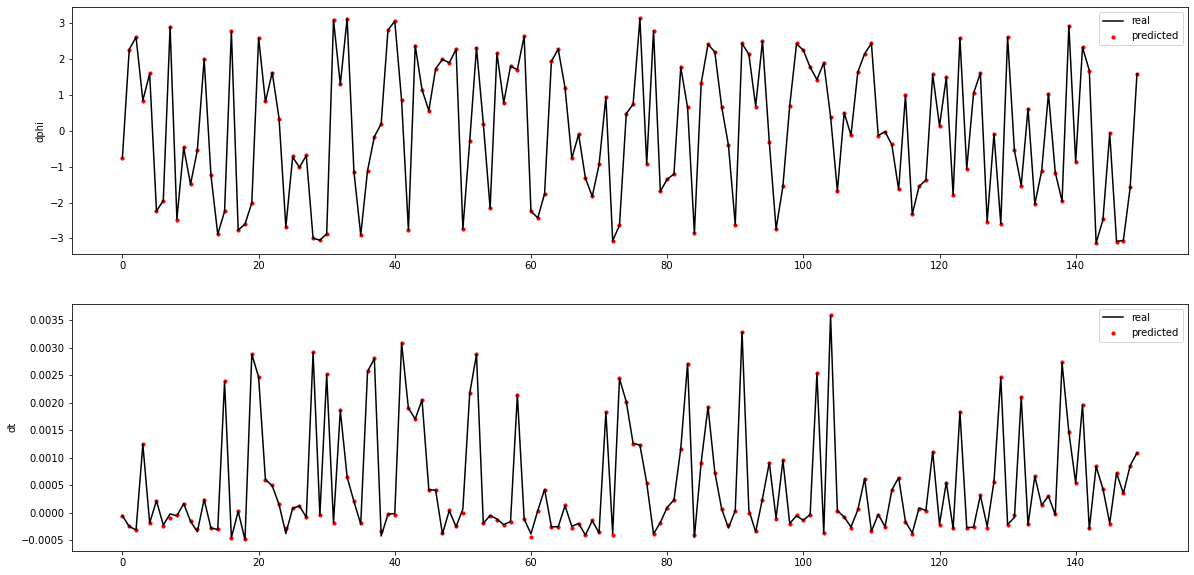

In [318]:
plt.figure(figsize=(20,10))
scatter_size = 10

plt.subplot(2,1,1)
plt.plot(np.arange(len(test_index)), true_dphi,label='real',color='k')
plt.scatter(np.arange(len(test_index)), predicted_dphi,label='predicted',s=scatter_size,color='r')
plt.ylabel('dphi')
plt.legend()


plt.subplot(2,1,2)
plt.plot(np.arange(len(test_index)), true_dt,label='real',color='k')
plt.scatter(np.arange(len(test_index)), predicted_dt,label='predicted',s=scatter_size,color='r')
plt.ylabel('dt')
plt.legend()

Text(0.5, 0, 'dt error')

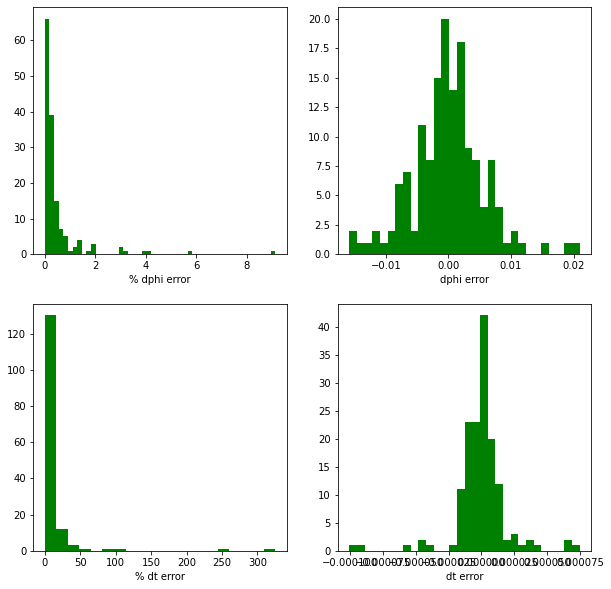

In [319]:
plt.figure(figsize=(10,10))
scatter_size = 10

plt.subplot(2,2,1)
x,xx,xxx = plt.hist(100*abs((true_dphi-predicted_dphi)/true_dphi),color='g',bins=50)
plt.xlabel('% dphi error')
#plt.legend()

plt.subplot(2,2,2)
x,xx,xxx = plt.hist(true_dphi-predicted_dphi,color='g',bins=30)
plt.xlabel('dphi error')


plt.subplot(2,2,3)
x,xx,xxx = plt.hist(100*abs((true_dt-predicted_dt)/true_dt),color='g',bins=20)
plt.xlabel('% dt error')

plt.subplot(2,2,4)
x,xx,xxx = plt.hist(true_dt-predicted_dt,color='g',bins=30)
plt.xlabel('dt error')
#plt.legend()

In [282]:
save_model_name = f'{output_folder}alignmodel_{phy}_{mode}_5d_q10a99.pickle'
torch.save(mlp, save_model_name)
#mlp = torch.load("my_model.pickle")